In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1 Load dataset


In [2]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255., x_test / 255.
y_train, y_test = y_train.flatten(), y_test.flatten() # labels are in shape (N x 1) but TensorFlow expects N

print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")

170498071/170498071 [==============================] - 34s 0us/step
x_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000,)


In [3]:
# number of class
K = len(set(y_train))
print(f"Number of classes: {K}")

Number of classes: 10


## 2 Build Model


In [4]:
kernel_size = (3, 3)
kernel_strides = 2 # img dimension halved after every convolution
dense_nodes = 1024

i = Input(shape=x_train[0].shape)
x = Conv2D(32, kernel_size, kernel_strides, activation = 'relu')(i) # filter here is 3 x 3 x 3 x 32
x = Conv2D(64, kernel_size, kernel_strides, activation='relu')(x)
x = Conv2D(128, kernel_size, kernel_strides, activation='relu')(x)

x = Flatten()(x) # convert image into single dimension feature vector for ANN
x = Dropout(0.2)(x) # for regularization
x = Dense(dense_nodes, activation='relu')(x)
x - Dropout(0.2)(x) # for regularization
x = Dense(K, activation='softmax')(x) # output layer

model = Model(i, x) # list / single input | list / single output

## 3 Compile & fit model


In [5]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=15
)

Epoch 1/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4795 - accuracy: 0.4616 - val_loss: 1.1937 - val_accuracy: 0.5642
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1385 - accuracy: 0.5929 - val_loss: 1.1145 - val_accuracy: 0.6051
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9593 - accuracy: 0.6591 - val_loss: 0.9650 - val_accuracy: 0.6578
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8301 - accuracy: 0.7076 - val_loss: 0.9416 - val_accuracy: 0.6740
Epoch 5/15
1563/1563 [==============================] - 7s 5ms/step - loss: 0.7120 - accuracy: 0.7482 - val_loss: 0.8811 - val_accuracy: 0.6924
Epoch 6/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6032 - accuracy: 0.7867 - val_loss: 0.8596 - val_accuracy: 0.7090
Epoch 7/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5059 - accuracy: 0.8208 - val_loss: 0.8872 - val_accuracy:

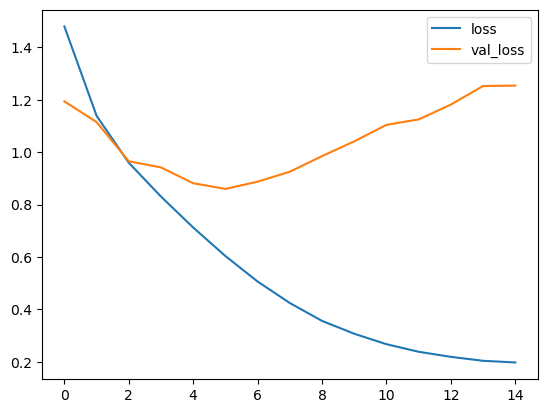

In [6]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

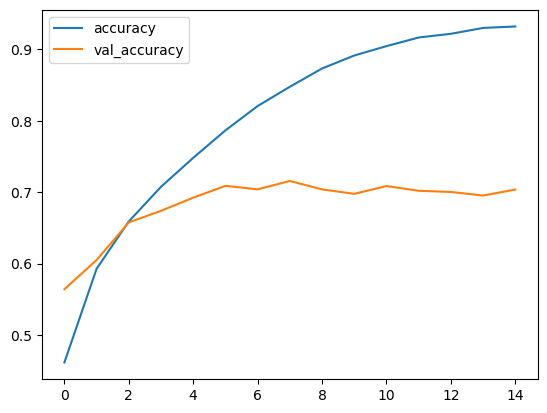

In [7]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

## 4 Perform prediction & evalute model


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

313/313 [==============================] - 1s 3ms/step


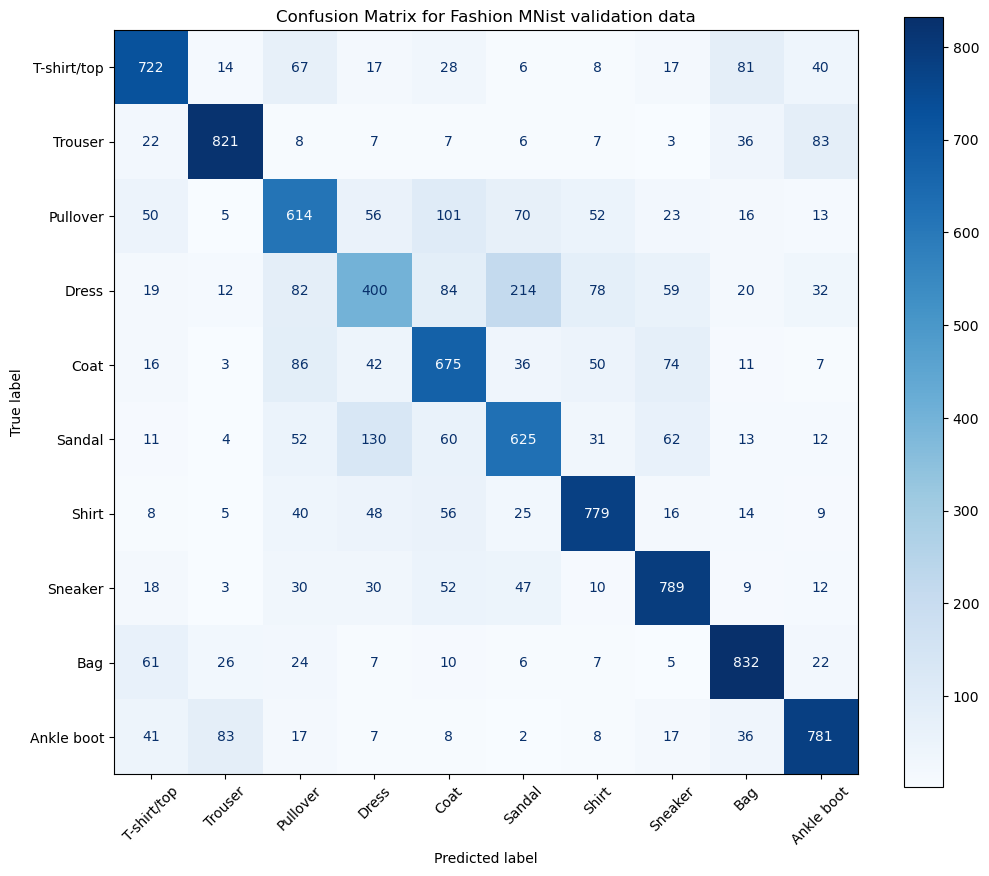

In [9]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) # convert probabilities to classes

conf_matrix = confusion_matrix(y_test, y_pred_classes, labels=range(K))
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fashion MNist validation data")
plt.xticks(rotation=45)
plt.show()

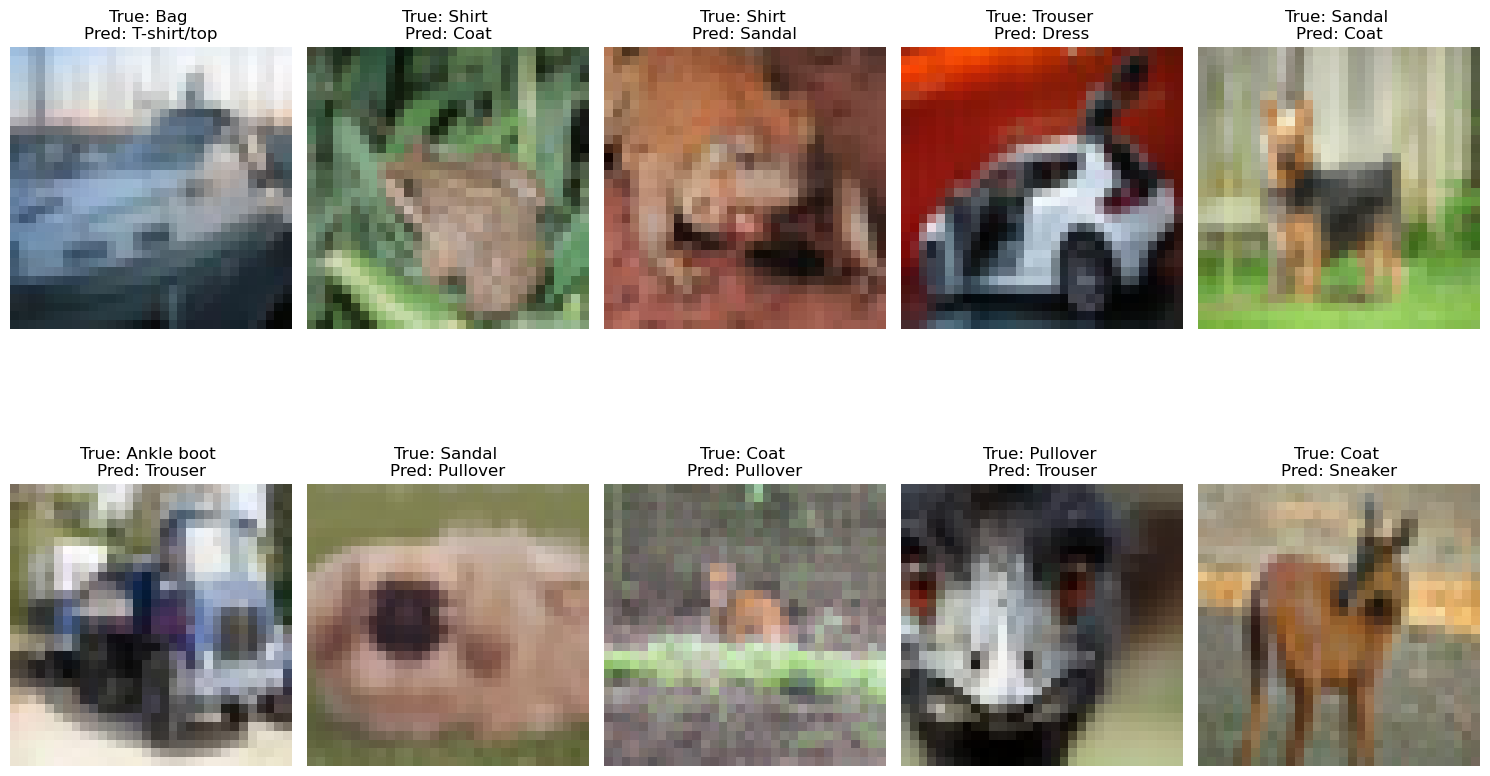

In [10]:
misclassified_idx = np.where(y_pred_classes != y_test)[0]

num_samples = 10
plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_idx[:num_samples]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {class_labels[y_test[idx]]} \nPred: {class_labels[y_pred_classes[idx]]}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()